# Final Machine Learning Pipeline

In [13]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
#from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from lightgbm import LGBMRegressor

from feature_engine.encoding import (
    OrdinalEncoder,
)

#from sklearn.preprocessing import PowerTransformer

from feature_engine.transformation import LogTransformer, YeoJohnsonTransformer

#import scipy.stats as stats
#from feature_engine.selection import DropFeatures
#from feature_engine.wrappers import SklearnTransformerWrapper

#from sklearn.preprocessing import StandardScaler

import Input.preprocessors as pp

import datetime

pd.pandas.set_option('display.max_columns', None)
#pd.pandas.set_option("future.no_silent_downcasting", True)


In [14]:
# load dataset
data = pd.read_csv('./input/train_coche.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1642, 10)


,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000


Quitamos etiquetas km y miles de variable running y convertimos a numérico

In [15]:

data["running"] = data["running"].astype(str)
data["running"] = data["running"].str.replace(" km","")
data["running"] = data["running"].str.replace(" miles","")
data["running"] = data["running"].astype(float)
data["running"]

0         3000.0
1       132000.0
2        95000.0
3       137000.0
4       130000.0
          ...   
1637    120000.0
1638    170000.0
1639     68900.0
1640     31000.0
1641        20.0
Name: running, Length: 1642, dtype: float64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1642 non-null   object 
 1   year          1642 non-null   int64  
 2   motor_type    1642 non-null   object 
 3   running       1642 non-null   float64
 4   wheel         1642 non-null   object 
 5   color         1642 non-null   object 
 6   type          1642 non-null   object 
 7   status        1642 non-null   object 
 8   motor_volume  1642 non-null   float64
 9   price         1642 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 128.4+ KB


**Valores Nulos**

No se encontraron valores nulos.

In [16]:
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]
data[vars_with_na].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

Variables Categóritcas

In [17]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars

['model', 'motor_type', 'wheel', 'color', 'type', 'status']

Variables Numéricas

In [18]:
num_vars = [var for var in data.columns if var not in cat_vars and var != 'price']
num_vars

['year', 'running', 'motor_volume']

Variables Temporales

In [19]:
year_vars = [var for var in num_vars if 'year' in var]
year_vars

['year']

Variables Discretas

In [20]:
discrete_vars = [var for var in num_vars if len(data[var].unique()) < 20]
discrete_vars

[]

Variables Continuas

In [21]:
cont_vars = [var for var in num_vars if var not in discrete_vars]
cont_vars


['year', 'running', 'motor_volume']

# Separamos dataset en train y test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price'], axis=1), # predictive variables
    data['price'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1477, 9), (165, 9))

In [31]:
y_train

817      8900
308     16800
1259     4700
240     17500
1503    17000
        ...  
763     10000
835     33000
1216    40000
559     15350
684     30000
Name: price, Length: 1477, dtype: int64

In [1]:
# index para yeo 
#y_train_i = y_train.index
#y_test_i = y_test.index

# Target

Aplicamos transformación logaritmica

In [23]:
y_train = np.log(y_train)
y_test = np.log(y_test)

Aplicamos tranformación yeo jhonson

In [22]:
tf = YeoJohnsonTransformer()
tf.fit(y_train.values.reshape(-1,1))

y_train_t = tf.transform(y_train.values.reshape(-1,1))
y_test_t = tf.transform(y_test.values.reshape(-1,1))

# para convertir a series
y_train_yeo=y_train_t.iloc[:,0]
y_test_yeo=y_test_t.iloc[:,0]

# setendo mismo index q particion original
y_train_yeo.index = y_train.index
# setendo mismo index q particion original
y_test_yeo.index = y_test.index

print(tf.lambda_dict_)
print(y_train_yeo)

{'x0': 0.39801520225246706}
817      91.251727
308     118.226639
1259     70.213229
240     120.204289
1503    118.796664
           ...    
763      95.702672
835     155.445966
1216    168.015062
559     113.966195
684     149.566244
Name: x0, Length: 1477, dtype: float64


In [23]:
y_train_yeo

817      91.251727
308     118.226639
1259     70.213229
240     120.204289
1503    118.796664
           ...    
763      95.702672
835     155.445966
1216    168.015062
559     113.966195
684     149.566244
Name: x0, Length: 1477, dtype: float64

# Configuración

In [24]:
# Variables temporales
TEMPORAL_VARS = ['year']
REF_VAR = datetime.datetime.now().year


# Variables para tranformaciion yeo 
NUMERICALS_YEO_VARS = ['running', 'motor_volume', 'year']
#NUMERICALS_YEO_VARS = ['year'] # Linear Regression

# Variables categoricas para codificar
CATEGORICAL_VARS = ['model', 'motor_type', 'color', 'type', 'status']
#CATEGORICAL_VARS = ['model']  # Linear Regression

# Variables seleccionadas del proceso feature selection
FEATURES = [
            'model',
            'year',
            'motor_type',
            'running',
            'color',
            'type',
            'status',
            'motor_volume',
]

In [25]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((1477, 8), (165, 8))

# Pipeline

- Transformación de variables temporales
- Yeo-johnson transformación de variables numéricas
- Ecoding de variables categoricas
- Aplicamos escalamiento
- Aplicamos modelo LGBMRegressor

In [26]:
X_train[CATEGORICAL_VARS] = X_train[CATEGORICAL_VARS].astype('category')

In [27]:
pipeline = Pipeline([

    # TEMPORAL VARIABLES
    ('calculated_time', pp.TemporalVariableTransformer(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR)),
    #('drop_features', DropFeatures(features_to_drop=[REF_VAR])),

    # VARIABLE TRANSFORMATION
     ('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),
     #('log', LogTransformer(variables=NUMERICALS_YEO_VARS)),
        
     # CATEGORICAL ENCODING
    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),
        
    # ESCALAMIENTO
    ('scaler', MinMaxScaler()),

    # MODELO
    #('Model', LinearRegression()),
    #('Lasso', Lasso(alpha=0.001, random_state=0)),
    ('model', LGBMRegressor())
])

**Usando y_train con tranformación logarítmica**

In [28]:
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 8
[LightGBM] [Info] Start training from score 9.572343


Pipeline(steps=[('calculated_time',
                 TemporalVariableTransformer(reference_variable=2024,
                                             variables=['year'])),
                ('yeojohnson',
                 YeoJohnsonTransformer(variables=['running', 'motor_volume',
                                                  'year'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['model', 'motor_type', 'color',
                                           'type', 'status'])),
                ('scaler', MinMaxScaler()), ('model', LGBMRegressor())])

In [77]:
#X_train = pipeline.transform(X_train)
#X_test = pipeline.transform(X_test)

In [29]:
pred = pipeline.predict(X_train)

# mse, rmse y r2 del X_train
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# predicciones con dataset test
pred = pipeline.predict(X_test)

# mse, rmse y r2 del X_test
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Precio del coche promedio: ', int(np.exp(y_train).median()))

train mse: 7545437
train rmse: 2746
train r2: 0.8567111175398352

test mse: 8128600
test rmse: 2851
test r2: 0.800045252139499

Precio del coche promedio:  15700


c:\Users\cmatos\AppData\Local\anaconda3\envs\env-mlops\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\cmatos\AppData\Local\anaconda3\envs\env-mlops\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [30]:
# guardamos pipeline
joblib.dump(pipeline, './Output/precio_coches_pipeline.joblib')

['./Output/precio_coches_pipeline.joblib']

Usando y_train y y_test con transformacion yeo

In [28]:
pipeline.fit(X_train, y_train_yeo)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 8
[LightGBM] [Info] Start training from score 112.929891


Pipeline(steps=[('calculated_time',
                 TemporalVariableTransformer(reference_variable=2024,
                                             variables=['year'])),
                ('yeojohnson',
                 YeoJohnsonTransformer(variables=['running', 'motor_volume',
                                                  'year'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['model', 'motor_type', 'color',
                                           'type', 'status'])),
                ('scaler', MinMaxScaler()), ('model', LGBMRegressor())])

In [29]:
# revertimos transformación de y_train
y_train_rev=tf.inverse_transform(y_train_t)

# convertimos a series aplicando el mismo index que y_train original
y_train_t_rev=y_train_rev.iloc[:,0]
y_train_t_rev.index = y_train.index

# revertimos transformación de y_test
y_test_rev=tf.inverse_transform(y_test_t)

# convertimos a series aplicando el mismo index que y_test original
y_test_t_rev=y_test_rev.iloc[:,0]
y_test_t_rev.index = y_test.index

In [30]:
# predicciones con dataset train

pred = pipeline.predict(X_train)
pred_rev = tf.inverse_transform(pred.reshape(-1, 1))

# mse, rmse y r2 del X_train
print('train mse: {}'.format(int(
    mean_squared_error(y_train_t_rev, pred_rev.to_numpy()))))
print('train rmse: {}'.format(int(
    mean_squared_error(y_train_t_rev, pred_rev.to_numpy(), squared=False))))
print('train r2: {}'.format(
    r2_score(y_train_t_rev, pred_rev.to_numpy())))
print()

# predicciones con dataset test
pred_test = pipeline.predict(X_test)
pred_test_rev = tf.inverse_transform(pred_test.reshape(-1, 1))

# mse, rmse y r2 del X_test
print('test mse: {}'.format(int(
    mean_squared_error(y_test_t_rev, pred_test_rev.to_numpy()))))
print('test rmse: {}'.format(int(
    mean_squared_error(y_test_t_rev, pred_test_rev.to_numpy(), squared=False))))
print('test r2: {}'.format(
    r2_score(y_test_t_rev, pred_test_rev.to_numpy())))
print()

print('Precio del coche promedio: ', int(y_train_t_rev.median()))

train mse: 6980040
train rmse: 2641
train r2: 0.8674480938981908

test mse: 7991284
test rmse: 2826
test r2: 0.8034230712022371

Precio del coche promedio:  15700


c:\Users\cmatos\AppData\Local\anaconda3\envs\env-mlops\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\cmatos\AppData\Local\anaconda3\envs\env-mlops\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
#pred_rev_test = tf.inverse_transform(pred.reshape(-1, 1))
#pred_rev_test

Identical results to when we did all the engineering manually.

Text(0.5, 1.0, 'Evaluación de predicciones (LGBMRegressor)')

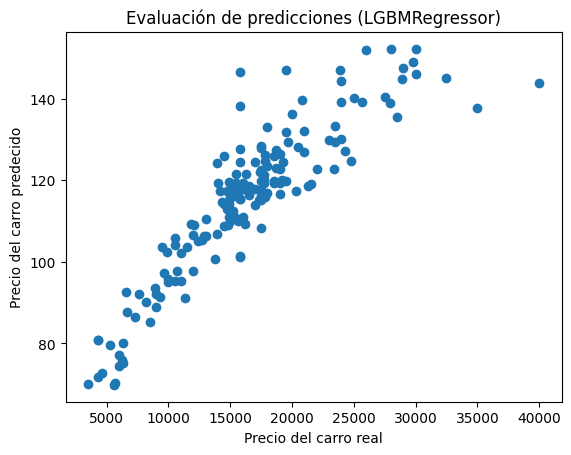

In [32]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, pipeline.predict(X_test))
plt.xlabel('Precio del carro real')
plt.ylabel('Precio del carro predecido')
plt.title('Evaluación de predicciones (LGBMRegressor)')

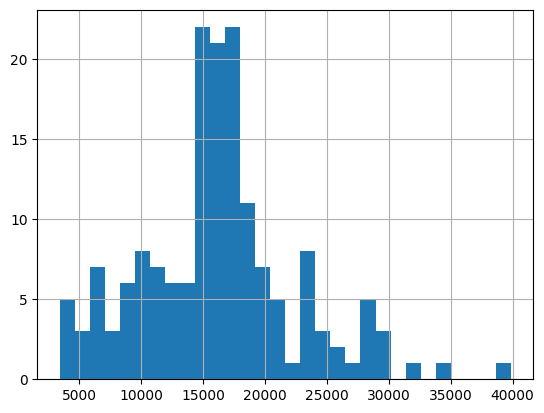

In [ ]:
# evaluación de distribución de errores:

y_test.reset_index(drop=True, inplace=True)
preds = pd.Series(pipeline.predict(X_test))
errors = y_test - preds
errors.hist(bins=30)
plt.show()

['./Output/precio_coches_pipeline.joblib']

TEST

In [15]:
# load the unseen / new dataset
data = pd.read_csv('./input/test_coche.csv')

data["running"] = data["running"].astype(str)
data["running"] = data["running"].str.replace(" km","")
data["running"] = data["running"].str.replace(" miles","")
data["running"] = data["running"].astype(float)
data["running"]

0       24000.0
1       85000.0
2       30000.0
3       53000.0
4      230000.0
         ...   
406     33400.0
407     60000.0
408    218000.0
409     40000.0
410    120000.0
Name: running, Length: 411, dtype: float64

In [16]:
data = data[FEATURES]

print(data.shape)

(411, 8)


In [17]:
data.head()

,model,year,motor_type,running,color,type,status,motor_volume
0,kia,2020,petrol,24000.0,black,sedan,excellent,2.0
1,nissan,2017,petrol,85000.0,white,suv,excellent,2.0
2,hyundai,2021,petrol,30000.0,white,sedan,excellent,2.0
3,kia,2018,petrol,53000.0,silver,sedan,excellent,2.0
4,mercedes-benz,2003,petrol,230000.0,black,Universal,normal,1.8


In [18]:
new_preds = pipeline.predict(data)

In [19]:
new_preds

array([ 9.74784408,  9.73126393, 10.1222351 ,  9.58845752,  8.68864125,
        9.77850014,  8.60743446,  8.87713786,  9.71910679,  9.90648719,
       10.16057697,  8.62991403,  9.52536011,  9.26714766,  9.76951182,
        9.21211541,  9.79446   ,  9.54657055,  9.56325869,  9.25470482,
        8.53148272,  8.53468265,  9.4994087 ,  9.75510514,  9.98010462,
        9.97898128,  9.99174015,  9.84238666,  8.58982901,  9.72723825,
        9.7403489 ,  9.49960534,  9.60021066,  8.59535903, 10.32165235,
        9.89943744,  9.29182357,  9.61879324,  9.76096276,  9.74366722,
        9.5917564 ,  9.78630835,  9.81547566, 10.2206492 ,  9.79577105,
        9.91427922,  9.5265916 ,  9.40042371,  9.84455134,  9.01996275,
        9.86643135,  8.72350425,  9.72850929,  9.72228601,  9.65741201,
        9.89110717, 10.03613271,  9.12138871,  9.29953295,  9.79065176,
        9.49203166,  9.7716421 ,  9.43154106, 10.00417627,  9.85647176,
        9.75410802,  9.51191642,  9.91284857, 10.20430549,  9.87

<Axes: >

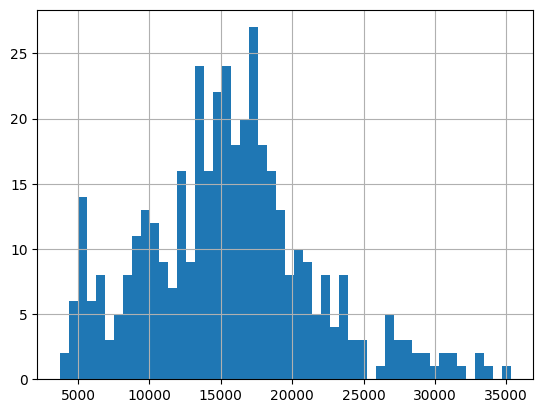

In [ ]:
pd.Series(np.exp(new_preds)).hist(bins=50)